In [2]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

In [3]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

In [4]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

### Source Code Citation: 
https://www.kaggle.com/code/asilpoyrazahin/tusimple-lane-detection

### Loading the dataset

In [5]:
#1. Import Necessary Liobraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm as notebook_tqdm
import tqdm
import tensorflow as tf

import pandas as pd
import numpy as np
from PIL import Image

import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1

from keras.optimizers import Adam
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#import torchvision.transforms as transforms

#import warnings
#warnings.filterwarnings("ignore")


### Dataset Information

#### Dataset Size
3626 video clips, 3626 labelled frames. 
Information of each clip: 20 frames for each one.

#### Directory Structure:
   		|
   		|----readme.md  				# description
   		|
   		|----clips/ 					# video clips, 3626 clips
   		|------|
   		|------|----0313-1/60/1.jpg	# Sequential images for the clip, Each folder within 0313-1/# holds 20 frames
   		|------|----...
   		|
   		|----label_data_0313.json			# Label data for lanes
   		|----label_data_0531.json			# Label data for lanes
   		|----label_data_0601.json			# Label data for lanes

In [6]:
### Code to assert a specific folder related to 

IMAGE_FOLDER = r"Z:\EE_297A\dataset\lanes\images"
MASK_FOLDER = r"Z:\EE_297A\dataset\lanes\masks"

In [7]:
### Function to create directories within the dataset folder:

def create_dirs_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created:", path)
    else:
        print("Directory already exists:", path)

In [8]:
create_dirs_if_not_exist(IMAGE_FOLDER)
create_dirs_if_not_exist(MASK_FOLDER)

Directory already exists: Z:\EE_297A\dataset\lanes\images
Directory already exists: Z:\EE_297A\dataset\lanes\masks


In [9]:
### Copy Images to  the Directory:
"""
This code is a data pre-processing script that goes through the TuSimple dataset’s
train_set/clips directory and copies only the 20th frame of each video clip into a single
flat folder to simplify training or dataset access.
"""
#-----------------------------------------------------------------------------------------
"""
Due to the dataset structure of the training set (dataset\lanes\TUSimple\train_set\clips\0313-1\#), 
First, we grab the image and mask associated with the 20th frame from each of the 3,626 folders in the train_set directory.
Then, we take that 20th image/mask, and store them in the IMAGE_FOLDER and MASK_FOLDER folder we created previously.
The purpose of this is because the dataset labels.json files are only for the 20th frame of each of the training clips. 
## Label Data Format
Each json line in 'label_data.json' is the label data for __the last (20th) frame__ of this clip.

"""
#-----------------------------------------------------------------------------------------

CLIPS_PATH = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new filename based on last 2 directory names
        clip_name = os.path.basename(os.path.dirname(frame_path))
        date_name = os.path.basename(os.path.dirname(os.path.dirname(frame_path)))
        new_filename = f"{date_name}_{clip_name}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, new_file_path)


Processing Clip: 0313-1
Processing Clip: 0313-2
Processing Clip: 0531
Processing Clip: 0601


In [10]:
print("Total images in dataset:", len(os.listdir(IMAGE_FOLDER)))

Total images in dataset: 3626


In [11]:
# load the dataset json files
"""
Code Purpose: Load and combine TuSimple lane label JSONs
lines=True tells pandas each line is a separate JSON object (which is true for TuSimple).
Each line describes a labeled frame's lanes + metadata.
"""

"""
For the ease of use of the one JSON file, we combine the json file into one dataframe for ease of use. 
"""

df1_313 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0313.json", lines = True)
df2_531 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0531.json", lines = True)
df3_601 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0601.json", lines = True)

# combine into single dataframe
df_json = pd.concat([df1_313, df2_531, df3_601])
print("""
{
  'raw_file': str. Clip file path.
  'lanes': list. A list of lanes. For each list of one lane, the elements are width values on image.
  'h_samples': list. A list of height values corresponding to the 'lanes', which means len(h_samples) == len(lanes[i])

    1.Each lane is a list of x-coordinates (width values in the image).
    2. The corresponding h_samples are the y-coordinates (height values in the image).
    3. Pairing lanes[i][j] with h_samples[j] gives you the pixel (x, y) of the lane marking on the image.
    4. So effectively, the dataset is describing polylines (lane centerlines/edges) in image coordinates.
}
""")
df_json.head()


{
  'raw_file': str. Clip file path.
  'lanes': list. A list of lanes. For each list of one lane, the elements are width values on image.
  'h_samples': list. A list of height values corresponding to the 'lanes', which means len(h_samples) == len(lanes[i])

    1.Each lane is a list of x-coordinates (width values in the image).
    2. The corresponding h_samples are the y-coordinates (height values in the image).
    3. Pairing lanes[i][j] with h_samples[j] gives you the pixel (x, y) of the lane marking on the image.
    4. So effectively, the dataset is describing polylines (lane centerlines/edges) in image coordinates.
}



lanes  \
0  [[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...   
1  [[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...   
2  [[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...   
3  [[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...   
4  [[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...   

                                           h_samples  \
0  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
1  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
2  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
3  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
4  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   

                    raw_file  
0   clips/0313-1/6040/20.jpg  
1   clips/0313-1/5320/20.jpg  
2  clips/0313-1/23700/20.jpg  
3  clips/0313-1/51660/20.jpg  
4  clips/0313-1/25680/20.jpg

### Creating the Masks
    1. What is a mask?
    Mask: Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.
    2. Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.

In [12]:
# create function for generating masks
"""
1. Creates an empty black mask image (728x1280).
2. Extracts lane info (lanes, h_samples) and the raw file path.
3. For each lane: Removes invalid points (-2).
5. Pairs valid (x, y) coordinates into lane points.
6. Draws a white polyline (thickness 15 px) on the mask.
7. Builds an output filename from the raw file path (e.g., 0313-1_5160.jpg).
8. Saves the mask image to the MASK FOLDER Previously created.
"""
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((728, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane = 1, non-lane = 0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed = False, color = (255, 255, 255), thickness = 15)
    
    # generate mask filename
    raw_file_path = os.path.normpath(raw_file)  # handles / vs \ properly
    clip_name = os.path.basename(os.path.dirname(raw_file_path))     # e.g., 5160
    date_name = os.path.basename(os.path.dirname(os.path.dirname(raw_file_path)))  # e.g., 0313-1
    mask_filename = f"{date_name}_{clip_name}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)

In [13]:
# generate masks
from tqdm import tqdm  #   Ensure this import is present

for index, row in tqdm(df_json.iterrows(), total=len(df_json)):
    generate_lane_mask(row)

100%|█████████████████████████████████████████████████████████████████████████████| 3626/3626 [00:10<00:00, 362.59it/s]


In [14]:

"""
Builds file paths for the road image (IMAGE_FOLDER) and its corresponding mask (MASK_FOLDER).

Reads the road image and converts it from BGR (OpenCV default) to RGB (for correct colors).

Reads the mask image.

Creates a Matplotlib figure with two subplots side by side.

Left subplot: shows the road image with the title "Road Image".

Right subplot: shows the mask in grayscale with the title "Ground Truth Mask".

Displays both images together for visual comparison.
"""
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)
    
    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    
    # plot the image
    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    
    # show the images
    plt.show()

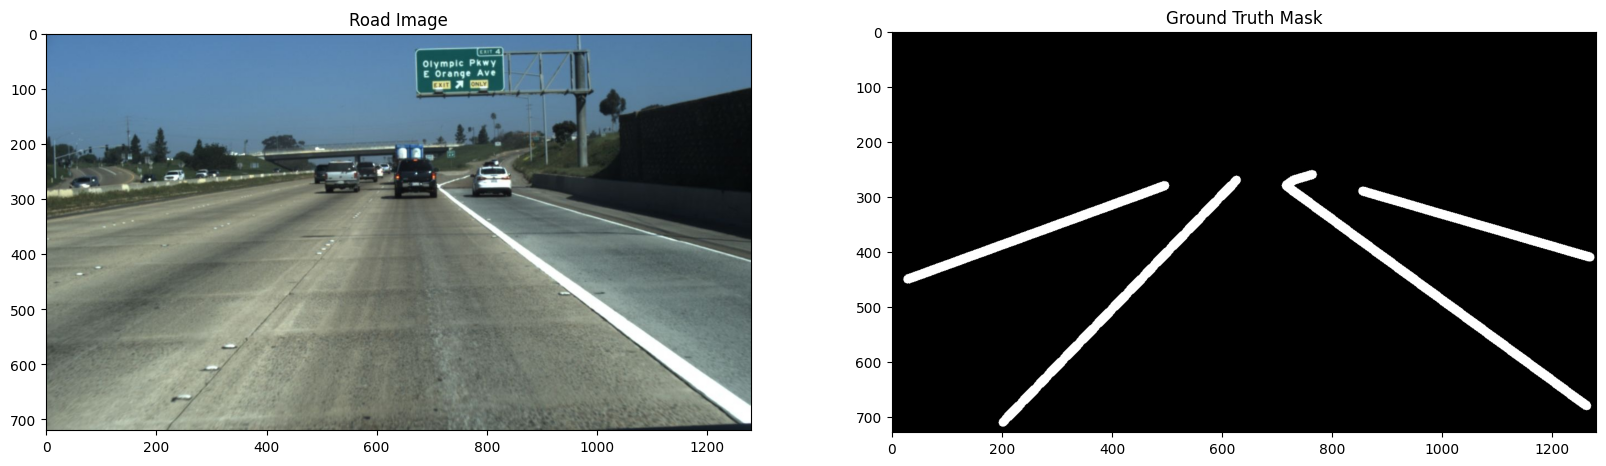

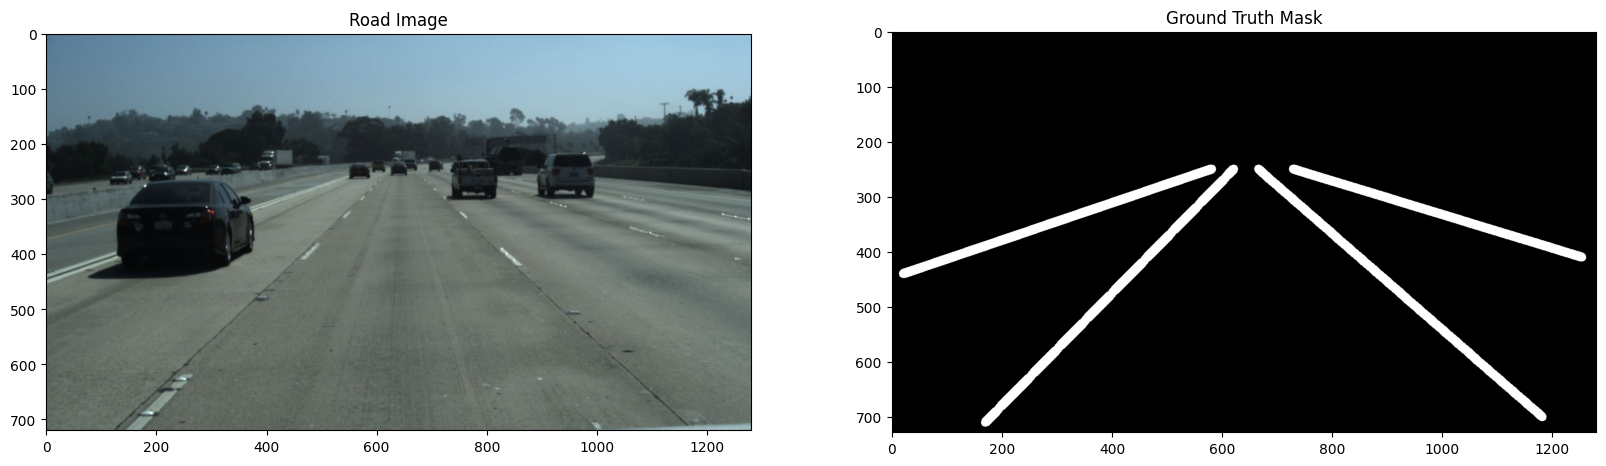

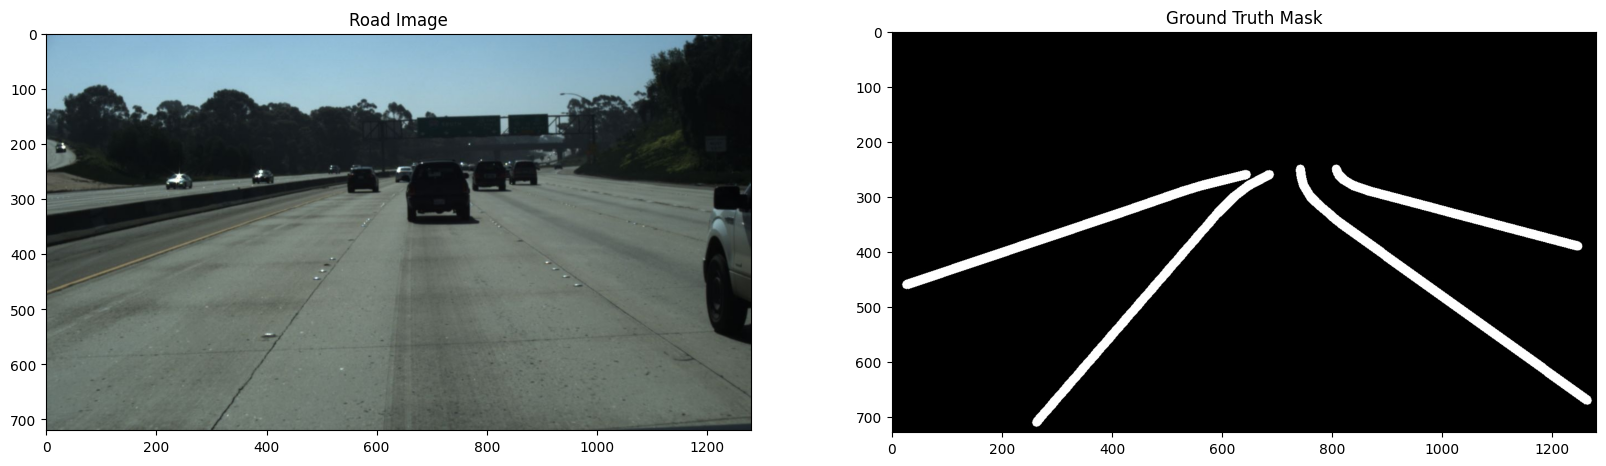

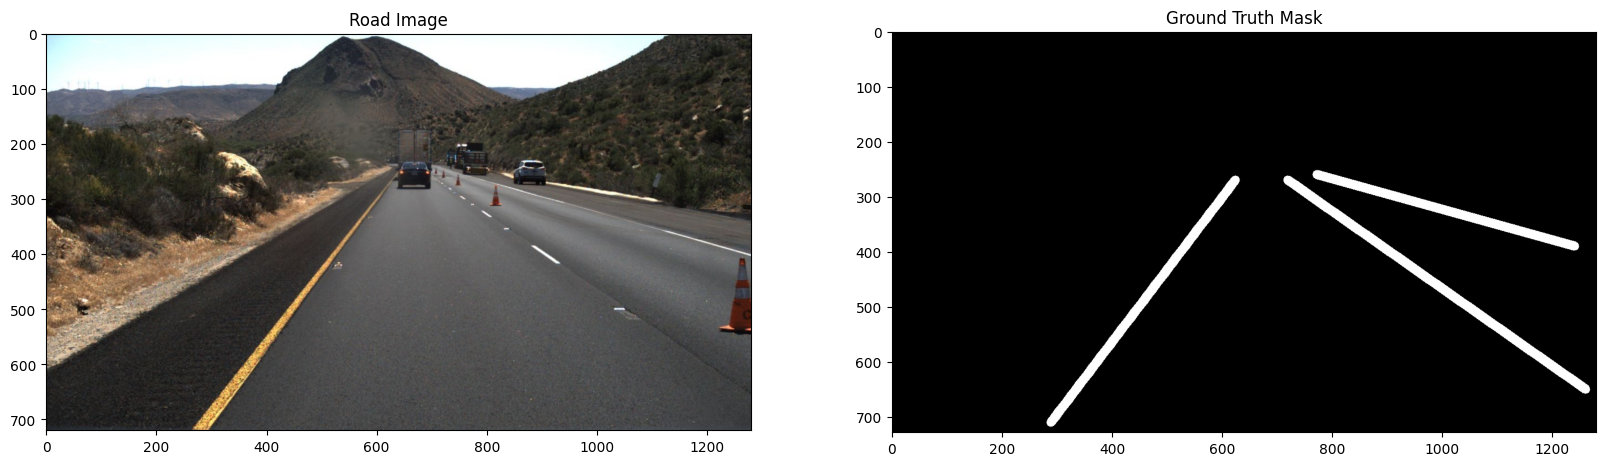

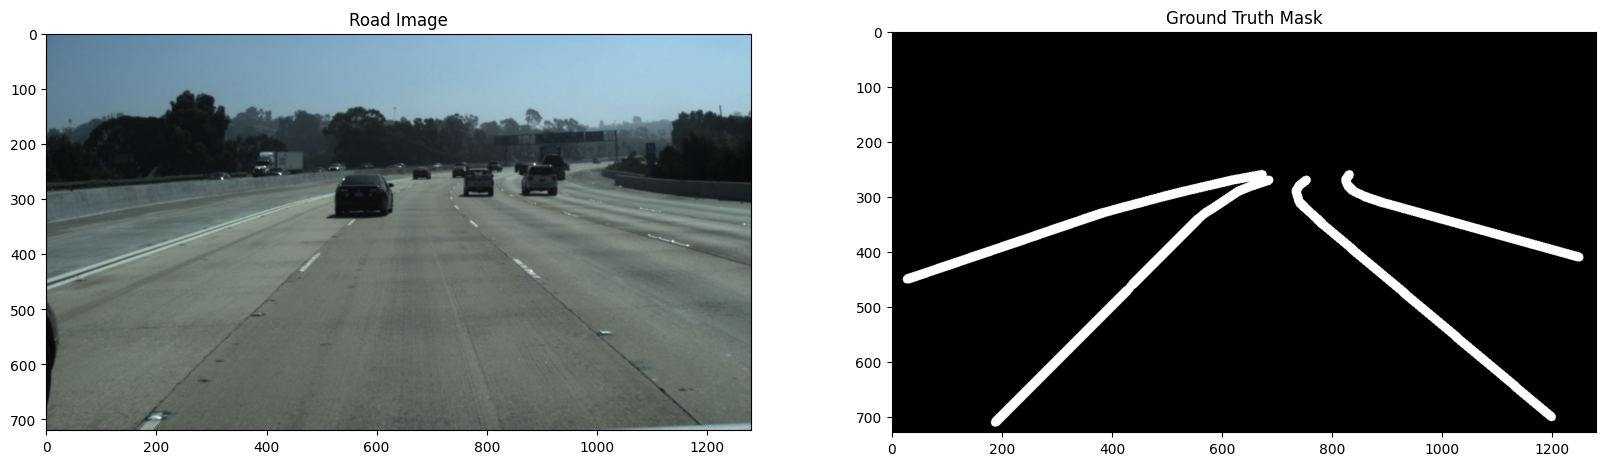

In [15]:
for i in range(5):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

In [16]:
print("Total masks in dataset:", len(os.listdir(MASK_FOLDER)))

Total masks in dataset: 3626


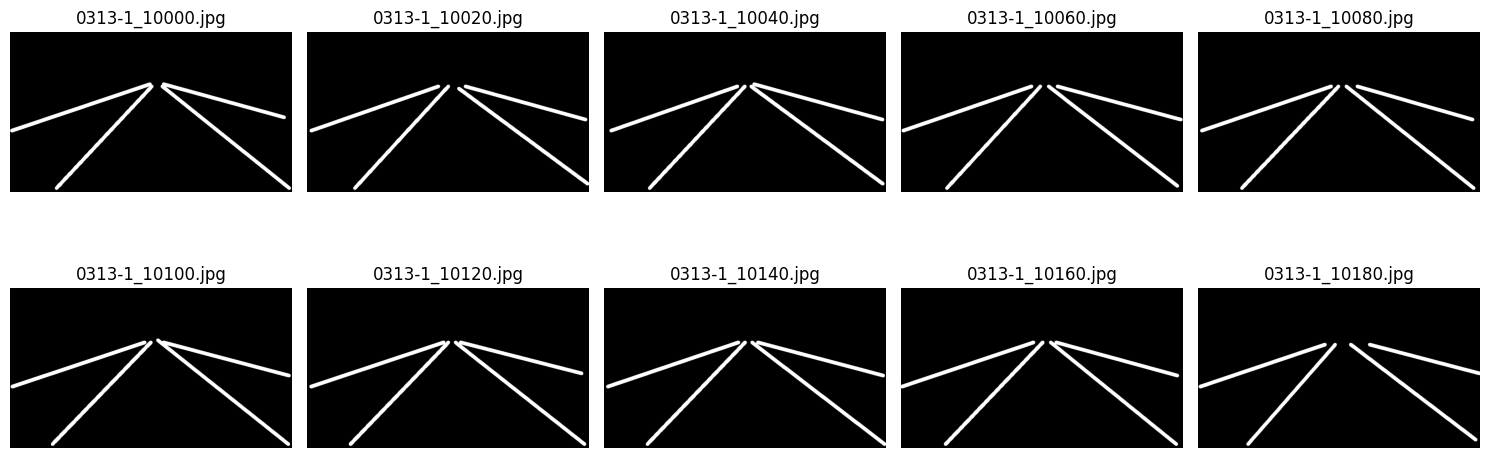

In [17]:
import os
import cv2
import matplotlib.pyplot as plt

# List all mask image files (sorted for consistency)
mask_files = sorted([
    f for f in os.listdir(MASK_FOLDER) if f.endswith(('.png', '.jpg'))
])[:10]

# Plot the first 10 masks
plt.figure(figsize=(15, 6))

for i, mask_file in enumerate(mask_files):
    mask_path = os.path.join(MASK_FOLDER, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 5, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(mask_file)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Training and Testing Splits and Processing
    1. Images
    2. Masks 

In [18]:
# Creating new directories to grab from IMAGE_FOLDER and MASK_FOLDER

lane_train_image_folder = r"Z:\EE_297A\dataset\lanes\train\images"
lane_test_image_folder = r"Z:\EE_297A\dataset\lanes\test\images"
lane_train_mask_folder = r"Z:\EE_297A\dataset\lanes\train\masks"
lane_test_mask_folder = r"Z:\EE_297A\dataset\lanes\test\masks"

In [19]:
for folder_path in [lane_train_image_folder, lane_test_image_folder, lane_train_mask_folder, lane_test_mask_folder]:
    create_dirs_if_not_exist(folder_path)

Directory already exists: Z:\EE_297A\dataset\lanes\train\images
Directory already exists: Z:\EE_297A\dataset\lanes\test\images
Directory already exists: Z:\EE_297A\dataset\lanes\train\masks
Directory already exists: Z:\EE_297A\dataset\lanes\test\masks


In [20]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith(".jpg")]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith(".jpg")]

# split for training and validation
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

### UNUSED CODE

### MODEL CREATION

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

"""
Main: Lightweight semantic segmentation model for lane detection
    built on MobileNetV2 as the encoder and a simple upsampling decoder

    Model Components:
1. Encoder (Feature Extractor)
    Uses MobileNetV2 from torchvision.models.
    Pretrained on ImageNet if pretrained=True.
    Extracts features up to the final convolution block (m.features).

2. Decoder (Segmentation Head)
    No skip connections (unlike U-Net) → lightweight and faster, but less spatial detail.
    Sequence of ConvTranspose2d (upsampling by 2) + Conv2d blocks.
    After each upsample, features are refined with Conv → BN → ReLU.
        Channel progression: 1280 → 256 → 128 → 64 → 32 → 1
    Spatial resolution progression (starting from 7×7): → 14 → 28 → 56 → 112
    Final output before interpolation: (B, 1, 112, 112) logits.
    
"""

class LaneSegOnlyMobileNetV2(nn.Module):
    def __init__(self, pretrained=True, freeze_stem=False):
        super().__init__()
        # ---- Encoder: MobileNetV2 ----
        weights = models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None
        m = models.mobilenet_v2(weights=weights)

        # Feature extractor (ends at last conv-bn-relu block)
        self.encoder = m.features              # output: (B, 1280, 7, 7) for 224x224
        enc_out_ch = 1280

        if freeze_stem:
            # freeze early, cheap speed/regularization trick
            for p in list(self.encoder.parameters())[:]:
                p.requires_grad = False

        # ---- Lightweight decoder (no skip connections) ----
        self.seg_head = nn.Sequential(
            nn.ConvTranspose2d(enc_out_ch, 256, kernel_size=2, stride=2),  # 7 -> 14
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),         # 14 -> 28
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),          # 28 -> 56
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),           # 56 -> 112
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),

            # Software design only upsamples to 112x112 (Half) becuase of easier hardware implementation.  
            # to get back to the full start resolution in the interpolation
            nn.Conv2d(32, 1, kernel_size=1),  # logits (B,1,112,112)
        )

    def forward(self, x):
        #Stores original height and width.
        H, W = x.shape[-2:]
        
        #Pass input x through MobileNetV2 encoder.
            #Output: compressed, high-level features.
        feats = self.encoder(x)                 # (B,1280,7,7) at 224x224

        #Output: compressed, high-level features.
            #Produces logits for one segmentation class (lane vs background).
        seg   = self.seg_head(feats)           # (B,1,112,112)
        
        """
        This upsamples the segmentation logits from (B,1,112,112) to match the **original input size (H, W)** (e.g., (B,1,224,224)` if input was 224×224).
        Interpolation is basically a resizing operation where
        Bilinear smoothly blend neighboring pixels to get a smoother mask.
        So here, interpolation = “resize the predicted mask to the original image resolution.”
        """
        seg   = F.interpolate(seg, size=(H, W), mode="bilinear", align_corners=False)
        #Returns per-pixel logits
        return seg


In [22]:
#model = LaneSegOnly().to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaneSegOnlyMobileNetV2(pretrained=True).to(device)

#output_seg = model(torch.randn(4, 3, 224, 224)).to(device)  # batch of 4
#print(output_seg.shape)  # -> (4, 1, 360, 640)

In [23]:
import os
import cv2
import torch
from torch.utils.data import Dataset

import os
import cv2
import torch
from torch.utils.data import Dataset

"""
Defines a custom PyTorch Dataset for the TuSimple lane segmentation dataset.

Inputs:
images_dir → folder with RGB road images.
masks_dir → folder with binary lane masks.
file_list → list of filenames to load.
transform (optional) → Albumentations-style augmentations.
include_class (optional) → if True, also returns a dummy class label.


__getitem__:
Loads an image and converts it from BGR → RGB.
Loads the corresponding mask in grayscale.
Resizes both to 224×224 (image with bilinear interpolation, mask with nearest neighbor).
Applies augmentations if provided (on both image & mask).
Binarizes mask to values {0,1}.
Converts:
Image → PyTorch tensor (3, H, W) normalized to [0,1].
Mask → PyTorch tensor (1, H, W) of floats.

Returns:
(image_tensor, mask_tensor) normally.
(image_tensor, dummy_class, mask_tensor) if include_class=True.
"""


class TuSimpleSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None, include_class=False):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.include_class = include_class  # if True, returns (img, 0, mask)

        # Ensure file_list is a list of strings
        self.file_list = [f if isinstance(f, str) else f.item() for f in file_list]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        if isinstance(fname, torch.Tensor):
            fname = fname.tolist()

        # --- Load image ---
        img_path = os.path.join(self.images_dir, fname)
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # --- Load mask ---
        mask_path = os.path.join(self.masks_dir, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        # Resize to model output (360x640)
        img  = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)       # image
        mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST) # 640, 360

        # --- Apply transforms (Albumentations-style) ---
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Binarize after transforms to get {0,1} as float
        mask = (mask > 127).astype("float32")

        # --- Convert to tensors ---
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0   # (3, H, W)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()             # (1, H, W)

        if self.include_class:
            dummy_class = torch.tensor(0, dtype=torch.long)
            return img_tensor, dummy_class, mask_tensor
        else:
            return img_tensor, mask_tensor

In [24]:
train_images_dir = lane_train_image_folder  # Z:\...\train\images
train_masks_dir  = lane_train_mask_folder
val_images_dir   = lane_test_image_folder   # Z:\...\test\images
val_masks_dir    = lane_test_mask_folder

In [25]:
images = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith(".jpg")]
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

In [26]:
# Step 2: instantiate datasets
lane_train_dataset = TuSimpleSegDataset(train_images_dir, train_masks_dir, lane_train_images)
lane_val_dataset   = TuSimpleSegDataset(val_images_dir, val_masks_dir, lane_val_images)

In [27]:
from torch.utils.data import DataLoader
"""
Batch Size: Split the dataset into mini-batches of images + masks.
Batch size = 16: Each training step feeds 16 images + 16 masks through the model

Gen Rule of Thumb: Smaller batch size → noisier updates, but less memory, can help generalization\
                    Larger batch size → smoother updates, faster on GPU, but needs more memory.
"""


lane_train_loader = DataLoader(lane_train_dataset, batch_size=16, shuffle=True)
lane_val_loader   = DataLoader(lane_val_dataset, batch_size=16, shuffle=False)


In [28]:
# Print Python version
import sys
sys.version

'3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]'

In [29]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.1


In [30]:
# Check GPU availability
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

CUDA available: True


In [31]:
if cuda_available:
    print("CUDA version (PyTorch built with):", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())
    print("Number of CUDA devices:", torch.cuda.device_count())

    for i in range(torch.cuda.device_count()):
        print(f"\n[GPU {i}]")
        print("Device Name:", torch.cuda.get_device_name(i))
        print("Device Capability:", torch.cuda.get_device_capability(i))
        print("Total Memory (MB):", round(torch.cuda.get_device_properties(i).total_memory / 1024**2, 2))
        print("Allocated Memory (MB):", round(torch.cuda.memory_allocated(i) / 1024**2, 2))
        print("Cached Memory (MB):", round(torch.cuda.memory_reserved(i) / 1024**2, 2))
else:
    print(" No CUDA-compatible GPU detected.")

CUDA version (PyTorch built with): 12.1
cuDNN version: 90100
Number of CUDA devices: 1

[GPU 0]
Device Name: NVIDIA GeForce RTX 3060 Ti
Device Capability: (8, 6)
Total Memory (MB): 8191.38
Allocated Memory (MB): 17.36
Cached Memory (MB): 28.0


In [32]:
# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Training Model: Only Rerun When ready

### OLD Training LOOP: Only Rerun When ready

### Training Model: Only Rerun When ready


Epoch 1/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.28it/s]


Train Loss: 0.0571


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.67it/s]


Val Loss: 0.0564

Epoch 2/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0460


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.98it/s]


Val Loss: 0.0546

Epoch 3/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.24it/s]


Train Loss: 0.0447


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.10it/s]


Val Loss: 0.0579

Epoch 4/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.25it/s]


Train Loss: 0.0426


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.98it/s]


Val Loss: 0.0555

Epoch 5/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0406


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.01it/s]


Val Loss: 0.0514

Epoch 6/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0397


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.06it/s]


Val Loss: 0.0528

Epoch 7/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.20it/s]


Train Loss: 0.0374


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.72it/s]


Val Loss: 0.0533

Epoch 8/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.24it/s]


Train Loss: 0.0368


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.94it/s]


Val Loss: 0.0536

Epoch 9/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.25it/s]


Train Loss: 0.0350


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.05it/s]


Val Loss: 0.0528

Epoch 10/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:49<00:00,  4.12it/s]


Train Loss: 0.0346


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.75it/s]


Val Loss: 0.0543

Epoch 11/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:52<00:00,  3.89it/s]


Train Loss: 0.0337


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.35it/s]


Val Loss: 0.0546

Epoch 12/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:02<00:00,  3.25it/s]


Train Loss: 0.0331


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  3.85it/s]


Val Loss: 0.0538

Epoch 13/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:05<00:00,  3.10it/s]


Train Loss: 0.0325


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.15it/s]


Val Loss: 0.0542

Epoch 14/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:51<00:00,  3.93it/s]


Train Loss: 0.0309


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.89it/s]


Val Loss: 0.0520

Epoch 15/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:49<00:00,  4.16it/s]


Train Loss: 0.0301


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.07it/s]


Val Loss: 0.0538

Epoch 16/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:51<00:00,  3.98it/s]


Train Loss: 0.0297


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.89it/s]


Val Loss: 0.0553

Epoch 17/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:51<00:00,  3.94it/s]


Train Loss: 0.0291


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.23it/s]


Val Loss: 0.0585

Epoch 18/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:51<00:00,  4.00it/s]


Train Loss: 0.0288


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.94it/s]


Val Loss: 0.0539

Epoch 19/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.18it/s]


Train Loss: 0.0282


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.04it/s]


Val Loss: 0.0540

Epoch 20/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:49<00:00,  4.16it/s]


Train Loss: 0.0269


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.75it/s]


Val Loss: 0.0559

Epoch 21/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:49<00:00,  4.09it/s]


Train Loss: 0.0269


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.36it/s]


Val Loss: 0.0562

Epoch 22/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:49<00:00,  4.15it/s]


Train Loss: 0.0263


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.59it/s]


Val Loss: 0.0559

Epoch 23/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:49<00:00,  4.12it/s]


Train Loss: 0.0259


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.65it/s]


Val Loss: 0.0566

Epoch 24/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.16it/s]


Train Loss: 0.0256


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.96it/s]


Val Loss: 0.0555

Epoch 25/25


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0250


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.88it/s]


Val Loss: 0.0582


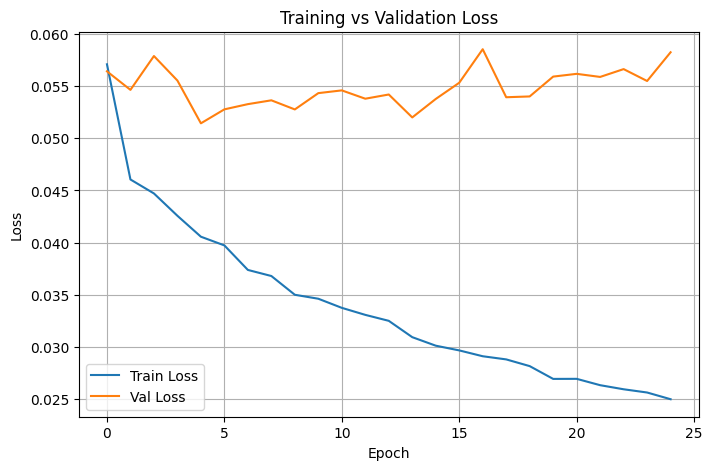

In [40]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Moves the model to GPU if available, otherwise runs on CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function = Binary Cross-Entropy with logits
criterion_seg = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# GradScaler: does mixed precision training (saves memory, speeds up training).
scaler = torch.amp.GradScaler(device.type)

# cudnn.benchmark = True: lets PyTorch pick the fastest algorithm for your GPU.
torch.backends.cudnn.benchmark = True

EPOCHS = 25

# Track losses per epoch
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0.0
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for images, masks in tqdm(lane_train_loader, desc="Train", leave=True):
        images = images.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device.type):   
            out_seg = model(images)
            if out_seg.shape[-2:] != masks.shape[-2:]:
                out_seg = F.interpolate(out_seg, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = criterion_seg(out_seg, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(lane_train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(lane_val_loader, desc="Val", leave=True):
            images = images.to(device, non_blocking=True)
            masks  = masks.to(device, non_blocking=True).float()

            with torch.amp.autocast(device.type):
                out_seg = model(images)
                if out_seg.shape[-2:] != masks.shape[-2:]:
                    out_seg = F.interpolate(out_seg, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion_seg(out_seg, masks)
            
            val_loss += loss.item()

    avg_val_loss = val_loss / len(lane_val_loader)
    print(f"Val Loss: {avg_val_loss:.4f}")
    val_losses.append(avg_val_loss)

# ---------------- PLOT LOSSES ----------------
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
# === Save model weights ===
torch.save(model.state_dict(), "lane_seg_weights_GRAPH.pth")
print(" Model weights saved to lane_seg_weights_GRAPH.pth")

 Model weights saved to lane_seg_weights_GRAPH.pth


### Loading Pretrained Model

In [33]:
model = LaneSegOnlyMobileNetV2()
model.load_state_dict(torch.load("lane_seg_weights_GRAPH.pth"))
model.to(device)
model.eval()  # set to inference mode

C:\Users\Baron\AppData\Local\Temp\ipykernel_8500\803664290.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lane_seg_weights_GRAPH.pth")

LaneSegOnlyMobileNetV2(
  (encoder): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2

In [35]:
# Define test folders (if not already defined)
test_images_dir = lane_test_image_folder
test_masks_dir  = lane_test_mask_folder

# Get test image filenames
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(".jpg")]

# Create the dataset
lane_test_dataset = TuSimpleSegDataset(test_images_dir, test_masks_dir, test_images)

#   Wrap in DataLoader
from torch.utils.data import DataLoader

lane_test_loader = DataLoader(lane_test_dataset, batch_size=16, shuffle=False)

In [36]:
import torch
import torch.nn as nn
from tqdm import tqdm

# === Loss Function (segmentation only) ===
# Since lane segmentation is binary (lane vs background), we use Binary Cross Entropy (BCE)
# Model outputs raw numbers (logits).ss

criterion_seg = nn.BCEWithLogitsLoss()

# === Metric: Dice Coefficient ===
def dice_coefficient(y_true, y_pred, threshold=0.5, eps=1e-7):
    # y_pred: raw logits -> sigmoid -> threshold -> {0,1}
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    intersection = (y_pred * y_true).sum(dim=(1, 2, 3))
    union = y_pred.sum(dim=(1, 2, 3)) + y_true.sum(dim=(1, 2, 3))
    dice = (2.0 * intersection + eps) / (union + eps)
    return dice.mean()

# === Test Loop (segmentation only) ===
test_loss = 0.0
dice_total = 0.0

model.eval()

with torch.no_grad():
    for batch in tqdm(lane_test_loader):
        # Support both (images, masks)
        # Load images and ground-truth masks from the test loader.
        if len(batch) == 3:
            images, _, masks = batch
        else:
            images, masks = batch

        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True).float()  # BCEWithLogitsLoss expects float

        # Run images through your segmentation model.
        out_seg = model(images)  # LaneSegOnly returns logits for the mask

        # Compare predictions to ground truth masks using BCEWithLogits.
        loss = criterion_seg(out_seg, masks)
        test_loss += loss.item()

        dice = dice_coefficient(masks, out_seg)
        dice_total += dice.item()

avg_test_loss = test_loss / len(lane_test_loader)
avg_dice_score = dice_total / len(lane_test_loader)

print("\ Test Results:")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Dice Score: {avg_dice_score:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.86it/s]

\ Test Results:
Test Loss: 0.0583
Dice Score: 0.7497


In [38]:
import matplotlib.pyplot as plt
import torch

def show_sample_prediction(model, dataset, device, index=0):
    model.eval()

    # --- Get sample from dataset ---
    sample = dataset[index]
    if len(sample) == 3:
        image, _, true_mask = sample   # if dataset returns (image, dummy_class, mask)
    else:
        image, true_mask = sample      # if dataset returns (image, mask)

    image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        pred_mask = model(image_tensor)           # LaneSegOnly → logits
        pred_mask = torch.sigmoid(pred_mask)      # Convert to probabilities
        pred_mask = (pred_mask > 0.5).float()     # Threshold at 0.5

    # --- Convert to numpy for visualization ---
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (C,H,W) → (H,W,C)
    true_np = true_mask.squeeze().cpu().numpy()
    pred_np = pred_mask.squeeze().cpu().numpy()

    # --- Plot ---
    plt.figure(figsize=(12, 4))
    titles = ["Input Image", "Ground Truth Mask", "Predicted Mask"]
    for i, img in enumerate([img_np, true_np, pred_np]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap="gray" if i > 0 else None)
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


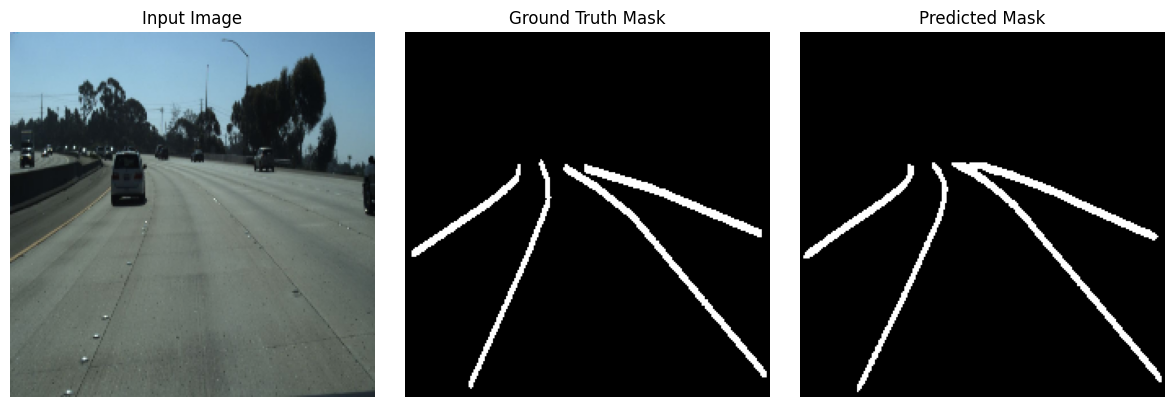

In [39]:
# Example: show first test image prediction
show_sample_prediction(model, lane_test_dataset, device, index=20)

In [40]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

def show_sample_prediction_overlay(model, dataset, device, index=0, alpha=0.4, color=(1, 0, 0)):
    model.eval()
    
    # --- Get sample from dataset ---
    sample = dataset[index]
    if len(sample) == 3:
        image, _, true_mask = sample   # dataset returns (image, dummy_class, mask)
    else:
        image, true_mask = sample      # dataset returns (image, mask)

    image_tensor = image.unsqueeze(0).to(device)  # (1, 3, H, W)

    with torch.no_grad():
        pred_mask = model(image_tensor)           # LaneSegOnly → logits
        pred_mask = torch.sigmoid(pred_mask)      # → probabilities
        pred_mask = (pred_mask > 0.5).float()     # → binary mask

    # --- Convert tensors to numpy ---
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
    pred_np = pred_mask.squeeze().cpu().numpy()    # (H', W')

    # 🔧 Resize pred mask to match original image size
    pred_np = cv2.resize(pred_np, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Normalize image to [0, 1] for display
    if img_np.max() > 1.0:
        img_np = img_np / 255.0

    # --- Create color overlay ---
    overlay = np.zeros_like(img_np)
    overlay[:, :, 0] = color[0]  # R
    overlay[:, :, 1] = color[1]  # G
    overlay[:, :, 2] = color[2]  # B

    # --- Apply overlay to predicted mask regions ---
    blended = img_np.copy()
    blended[pred_np == 1] = (1 - alpha) * blended[pred_np == 1] + alpha * overlay[pred_np == 1]

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(blended)
    plt.title("Overlay: Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


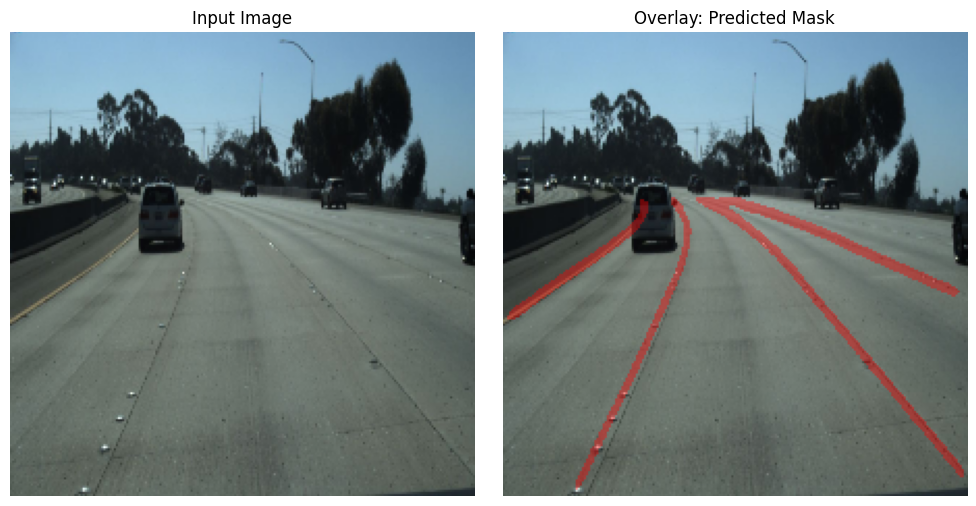

In [41]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=20, alpha=0.4)

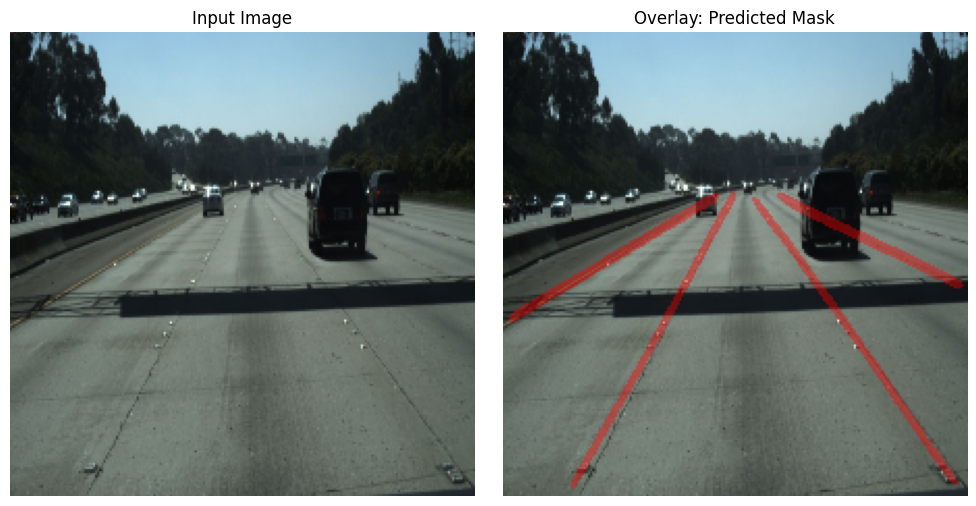

In [42]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=1, alpha=0.4)

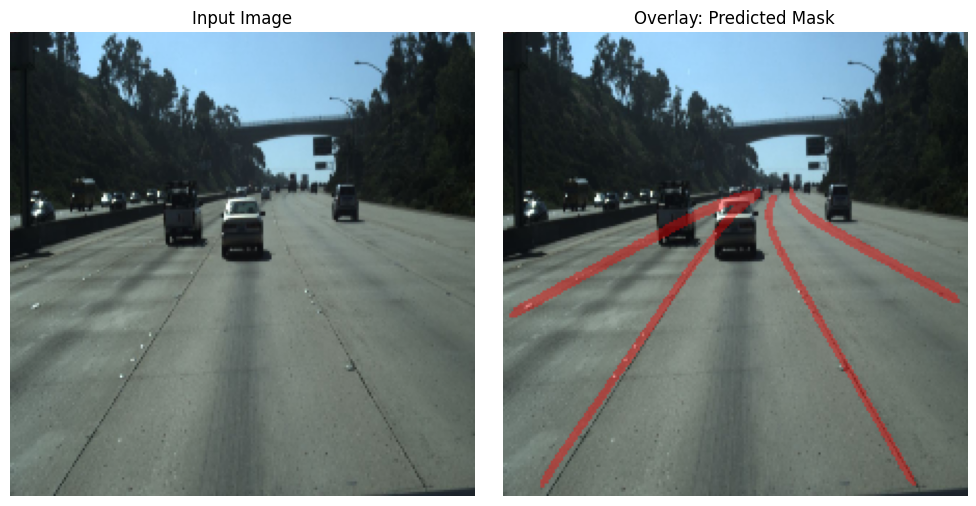

In [43]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=100, alpha=0.4)

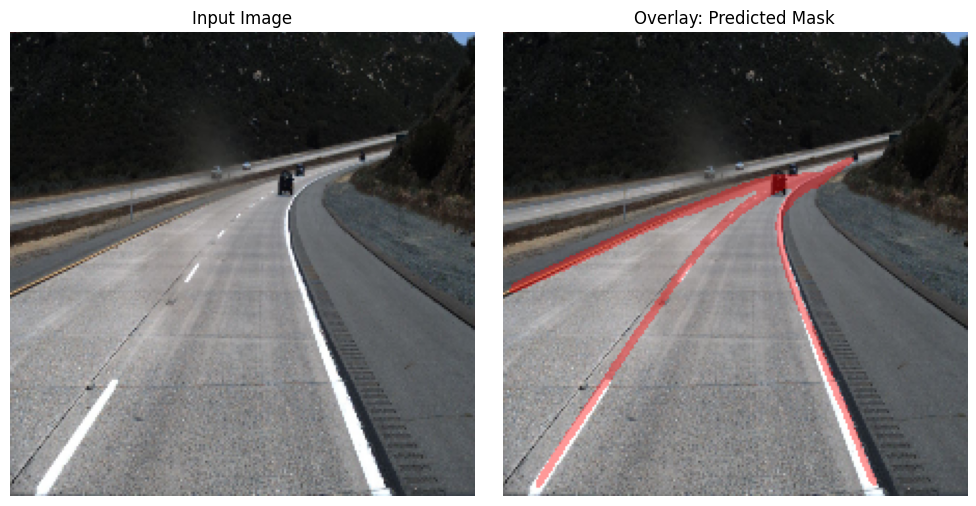

In [44]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=300, alpha=0.4)